<a href="https://colab.research.google.com/github/Oxshadha/Bio-Fusion/blob/main/EfficientNet%2BViT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Shared utilities for multi-model training in Google Colab
Avoids code duplication across different model experiments
"""

import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, matthews_corrcoef
)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch.nn.functional as F

# ============================================================================
# CONFIGURATION
# ============================================================================

# Dataset path for Google Colab
DATASET_PATH = "/content/GCHTID/HMU-GC-HE-30K/all_image"

# Model saving directory (Google Drive)
MODEL_SAVE_DIR = "/content/drive/MyDrive/BioFusion_Models"

# Classes
CLASSES = ['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']
NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

# Training hyperparameters
RANDOM_SEED = 42
BATCH_SIZE = 32
NUM_EPOCHS_PHASE1 = 10
NUM_EPOCHS_PHASE2 = 10
EARLY_STOP_PATIENCE = 5

# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# ============================================================================
# REPRODUCIBILITY
# ============================================================================

def set_seeds(seed=RANDOM_SEED):
    """Set all random seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# ============================================================================
# DEVICE SETUP
# ============================================================================

def get_device():
    """Get the best available device (CUDA > CPU)"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✓ Using CUDA: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("⚠ Using CPU")
    return device

# ============================================================================
# GOOGLE DRIVE SETUP (for model persistence)
# ============================================================================

def setup_google_drive():
    """Mount Google Drive and create model directory"""
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=False)
        print("✓ Google Drive mounted")
    except Exception as e:
        print(f"⚠ Google Drive mount issue: {e}")
        print("  Models will be saved locally only")
        return None

    # Create model directory
    model_dir = '/content/drive/MyDrive/BioFusion_Models'
    os.makedirs(model_dir, exist_ok=True)
    print(f"✓ Model directory ready: {model_dir}")
    return model_dir

def save_model_and_results(model, results, model_name, save_to_drive=True):
    """
    Save model weights and results to both local and Google Drive

    Args:
        model: Trained PyTorch model
        results: Results dictionary
        model_name: Name for the model (e.g., 'resnet50', 'vit_base')
        save_to_drive: Whether to save to Google Drive
    """
    # Save model weights locally
    local_model_path = f'{model_name}_final.pt'
    torch.save(model.state_dict(), local_model_path)
    print(f"✓ Model saved locally: {local_model_path}")

    # Save results locally
    local_results_path = f'{model_name}_results.json'
    with open(local_results_path, 'w') as f:
        json.dump({
            'test_acc': float(results['test_acc']),
            'macro_f1': float(results['macro_f1']),
            'weighted_f1': float(results['weighted_f1']),
            'mcc': float(results['mcc']),
            'per_class_f1': results['per_class_f1'].tolist()
        }, f, indent=2)
    print(f"✓ Results saved locally: {local_results_path}")

    # Save to Google Drive if available
    if save_to_drive:
        try:
            model_dir = setup_google_drive()
            if model_dir:
                drive_model_path = os.path.join(model_dir, f'{model_name}_final.pt')
                drive_results_path = os.path.join(model_dir, f'{model_name}_results.json')

                torch.save(model.state_dict(), drive_model_path)
                with open(drive_results_path, 'w') as f:
                    json.dump({
                        'test_acc': float(results['test_acc']),
                        'macro_f1': float(results['macro_f1']),
                        'weighted_f1': float(results['weighted_f1']),
                        'mcc': float(results['mcc']),
                        'per_class_f1': results['per_class_f1'].tolist()
                    }, f, indent=2)

                print(f"✓ Model saved to Google Drive: {drive_model_path}")
                print(f"✓ Results saved to Google Drive: {drive_results_path}")
        except Exception as e:
            print(f"⚠ Could not save to Google Drive: {e}")
            print("  Models saved locally only (still accessible)")

    return local_model_path, local_results_path

# ============================================================================
# FOCAL LOSS (for hard examples)
# ============================================================================

class FocalLoss(nn.Module):
    """
    Focal Loss for addressing hard examples and class confusion
    FL(p_t) = -α(1-p_t)^γ * log(p_t)

    Better than CrossEntropyLoss for:
    - Hard examples (NOR, DEB, STR confusion)
    - Balanced datasets with varying difficulty

    Args:
        alpha: Weighting factor (default: 0.25)
        gamma: Focusing parameter (default: 2.0) - higher = more focus on hard examples
        reduction: 'mean' or 'sum'
    """
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # Probability of true class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ============================================================================
# DATASET LOADING
# ============================================================================

def load_dataset_paths(dataset_root=DATASET_PATH):
    """Load all image paths and labels"""
    image_paths = []
    labels = []

    for class_name in CLASSES:
        class_dir = os.path.join(dataset_root, class_name)
        if os.path.exists(class_dir):
            class_files = [f for f in os.listdir(class_dir) if f.endswith('.png')]
            for filename in class_files:
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(CLASS_TO_IDX[class_name])

    print(f"Loaded {len(image_paths)} images from {len(CLASSES)} classes")
    return image_paths, labels

def create_splits(image_paths, labels, test_size=0.15, val_size=0.15, seed=RANDOM_SEED):
    """Create stratified train/val/test splits"""
    # First split: train vs (val+test)
    X_temp, X_test, y_temp, y_test = train_test_split(
        image_paths, labels, test_size=test_size,
        random_state=seed, stratify=labels
    )

    # Second split: val vs test
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size),
        random_state=seed, stratify=y_temp
    )

    print(f"Train: {len(X_train)} ({len(X_train)/len(image_paths)*100:.1f}%)")
    print(f"Val: {len(X_val)} ({len(X_val)/len(image_paths)*100:.1f}%)")
    print(f"Test: {len(X_test)} ({len(X_test)/len(image_paths)*100:.1f}%)")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# ============================================================================
# DATASET CLASS
# ============================================================================

class HistopathologyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# ============================================================================
# TRANSFORMS
# ============================================================================

def get_transforms(augment=True):
    """Get data transforms (with or without augmentation)"""
    if augment:
        # Training: light augmentation
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            # Reduced rotation: ±15° instead of ±90°
            transforms.RandomRotation(degrees=15),
            # Removed color jitter (too aggressive)
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])
    else:
        # Validation/Test: only normalization
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])
    return transform

# ============================================================================
# DATA LOADERS
# ============================================================================

def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test,
                       batch_size=BATCH_SIZE, num_workers=2):
    """Create train/val/test dataloaders"""
    train_transform = get_transforms(augment=True)
    val_test_transform = get_transforms(augment=False)

    train_dataset = HistopathologyDataset(X_train, y_train, transform=train_transform)
    val_dataset = HistopathologyDataset(X_val, y_val, transform=val_test_transform)
    test_dataset = HistopathologyDataset(X_test, y_test, transform=val_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

# ============================================================================
# EVALUATION FUNCTIONS
# ============================================================================

def evaluate_model(model, test_loader, criterion, device):
    """Evaluate model on test set"""
    test_loss, test_acc, test_preds, test_labels = validate(
        model, test_loader, criterion, device
    )

    # Classification report
    class_names = [IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]
    report = classification_report(
        test_labels, test_preds,
        target_names=class_names,
        digits=4,
        output_dict=True
    )

    # Overall metrics
    macro_f1 = f1_score(test_labels, test_preds, average='macro')
    weighted_f1 = f1_score(test_labels, test_preds, average='weighted')
    mcc = matthews_corrcoef(test_labels, test_preds)

    # Per-class F1
    per_class_f1 = f1_score(test_labels, test_preds, average=None)

    results = {
        'test_loss': test_loss,
        'test_acc': test_acc,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'mcc': mcc,
        'per_class_f1': per_class_f1,
        'predictions': test_preds,
        'labels': test_labels,
        'classification_report': report
    }

    return results

def plot_confusion_matrix(y_true, y_pred, model_name, save_path=None):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    class_names = [IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{model_name} - Confusion Matrix (Counts)',
                     fontsize=14, fontweight='bold')

    # Normalized
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Normalized'})
    axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{model_name} - Confusion Matrix (Normalized)',
                     fontsize=14, fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_per_class_f1(per_class_f1_dict, save_path=None):
    """Plot per-class F1 scores for all models"""
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(CLASSES))
    width = 0.2
    offset = 0

    for model_name, f1_scores in per_class_f1_dict.items():
        ax.bar(x + offset, f1_scores, width, label=model_name)
        offset += width

    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    ax.set_title('Per-Class F1 Scores Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * (len(per_class_f1_dict) - 1) / 2)
    ax.set_xticklabels(CLASSES)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# EMBEDDING VISUALIZATION
# ============================================================================

def extract_features(model, test_loader, device, num_samples=500):
    """Extract features from penultimate layer"""
    model.eval()
    features_list = []
    labels_list = []

    # Hook to extract features
    def get_features_hook(module, input, output):
        features_list.append(output.view(output.size(0), -1).cpu().numpy())

    # Register hook (assumes model has backbone.avgpool)
    if hasattr(model, 'backbone') and hasattr(model.backbone, 'avgpool'):
        hook = model.backbone.avgpool.register_forward_hook(get_features_hook)
    elif hasattr(model, 'avgpool'):
        hook = model.avgpool.register_forward_hook(get_features_hook)
    else:
        print("Warning: Could not find avgpool layer for feature extraction")
        return None, None

    count = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if count >= num_samples:
                break
            images = images.to(device)
            _ = model(images)
            labels_list.extend(labels.numpy())
            count += len(labels)

    hook.remove()

    if features_list:
        features_array = np.vstack(features_list)
        labels_array = np.array(labels_list[:len(features_array)])
        return features_array, labels_array
    return None, None

def plot_tsne(features, labels, model_name, save_path=None):
    """Plot t-SNE visualization"""
    from sklearn.manifold import TSNE

    print(f"Computing t-SNE for {model_name}...")
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, n_iter=1000)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(12, 10))
    for class_idx in range(NUM_CLASSES):
        mask = labels == class_idx
        if np.sum(mask) > 0:
            plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                       label=IDX_TO_CLASS[class_idx], alpha=0.6, s=50)

    plt.xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
    plt.ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
    plt.title(f'{model_name} - t-SNE Visualization', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# MODEL COMPARISON
# ============================================================================

def compare_models(results_dict, save_path=None):
    """Compare multiple models' performance"""
    models = list(results_dict.keys())
    metrics = ['test_acc', 'macro_f1', 'weighted_f1', 'mcc']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        values = [results_dict[model][metric] for model in models]
        axes[idx].bar(models, values, color='steelblue', edgecolor='black')
        axes[idx].set_ylabel(metric.replace('_', ' ').title(),
                             fontsize=12, fontweight='bold')
        axes[idx].set_title(f'{metric.replace("_", " ").title()} Comparison',
                           fontsize=12, fontweight='bold')
        axes[idx].grid(axis='y', alpha=0.3)

        # Add value labels
        for i, v in enumerate(values):
            axes[idx].text(i, v + 0.01, f'{v:.4f}',
                          ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary table
    print("\n" + "="*80)
    print("MODEL COMPARISON SUMMARY")
    print("="*80)
    print(f"{'Model':<20} {'Accuracy':<12} {'Macro F1':<12} {'Weighted F1':<12} {'MCC':<12}")
    print("-"*80)
    for model in models:
        r = results_dict[model]
        print(f"{model:<20} {r['test_acc']:<12.4f} {r['macro_f1']:<12.4f} "
              f"{r['weighted_f1']:<12.4f} {r['mcc']:<12.4f}")
    print("="*80)

Streaming output truncated to the last 5000 lines.
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3537.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3538.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3539.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_354.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3540.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3541.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3542.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3543.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3544.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3545.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3546.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3547.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3548.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3549.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_355.png  
  infl

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

HYBRID MODEL ARCHITECTURE
Combining:
  - EfficientNet-B4 (CNN features)
  - ViT-Base (Transformer features)
  - Late fusion: Concatenate features → Classifier
✓ Using Focal Loss (alpha=0.25, gamma=2.0) for hard examples

PHASE 1: Training Classifier (Both Backbones Frozen)
Using 10 epochs for hybrid model
Epoch [1/10]
  Train: Loss=0.2085, Acc=49.71%
  Val: Loss=0.1614, Acc=58.63%
  Train-Val Gap: -8.92%
  ✓ Best model saved
Epoch [2/10]
  Train: Loss=0.1856, Acc=53.74%
  Val: Loss=0.1703, Acc=56.10%
  Train-Val Gap: -2.36%
Epoch [3/10]
  Train: Loss=0.1811, Acc=54.73%
  Val: Loss=0.1558, Acc=60.69%
  Train-Val Gap: -5.96%
  ✓ Best model saved
Epoch [4/10]
  Train: Loss=0.1794, Acc=54.57%
  Val: Loss=0.1489, Acc=61.59%
  Train-Val Gap: -7.02%
  ✓ Best model saved
Epoch [5/10]
  Train: Loss=0.1758, Acc=55.03%
  Val: Loss=0.1485, Acc=61.31%
  Train-Val Gap: -6.28%
  ✓ Best model saved
Epoch [6/10]
  Train: Loss=0.1738, Acc=55.52%
  Val: Loss=0.1535, Acc=60.75%
  Train-Val Gap: -5.23%
Epo

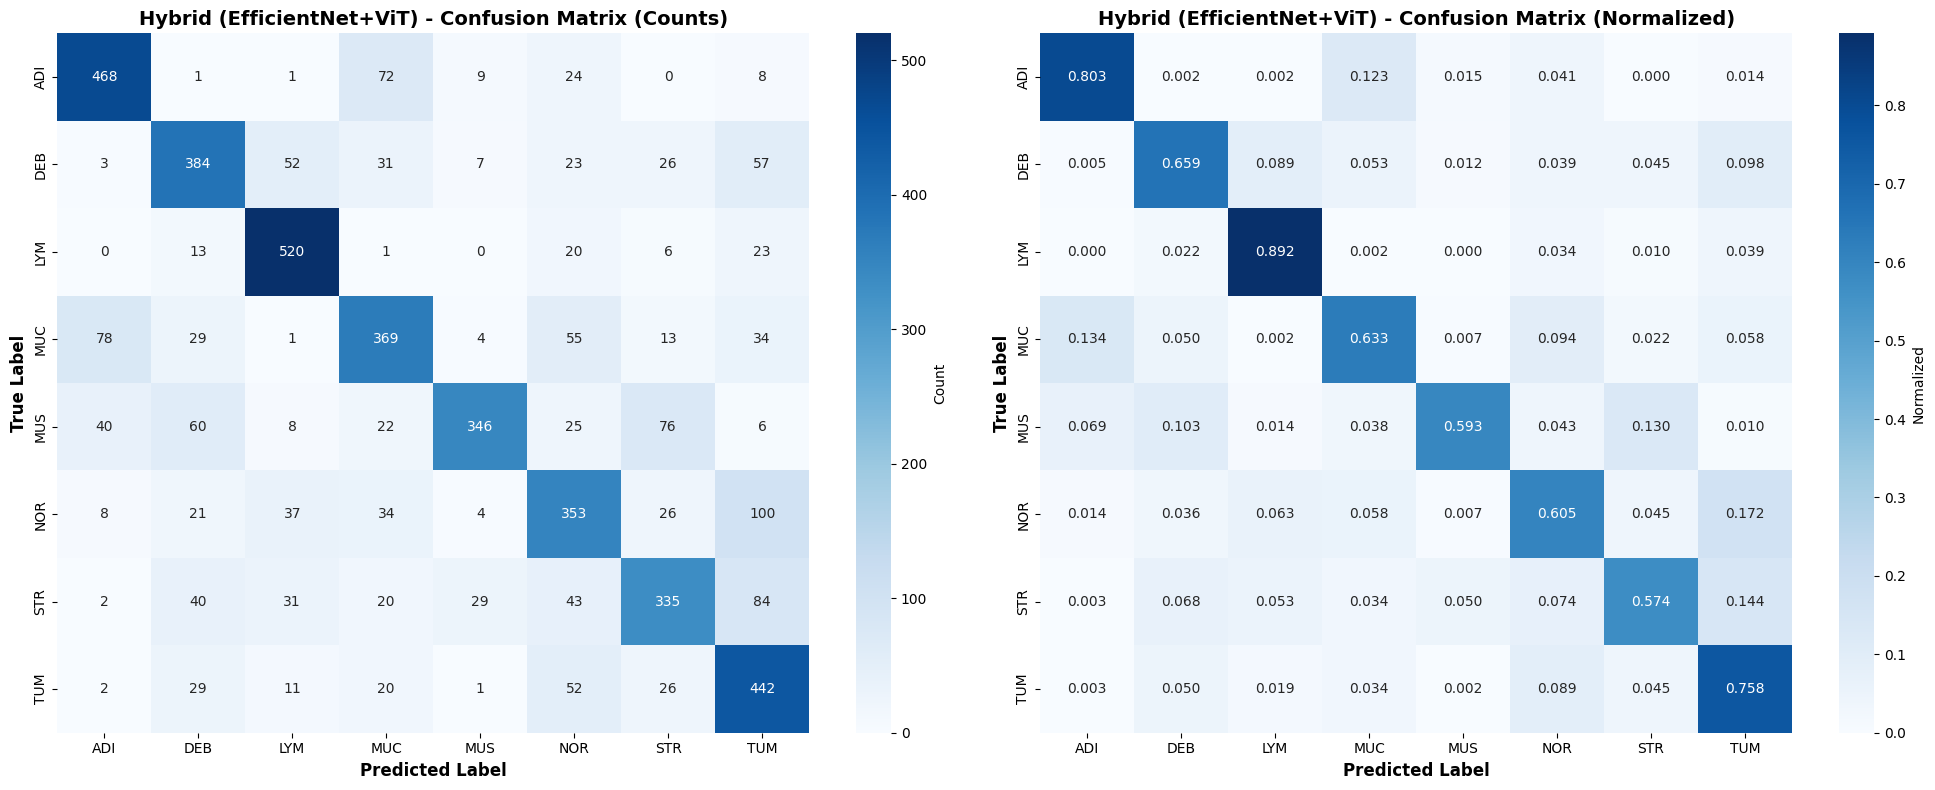

Computing t-SNE for Hybrid (EfficientNet+ViT)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


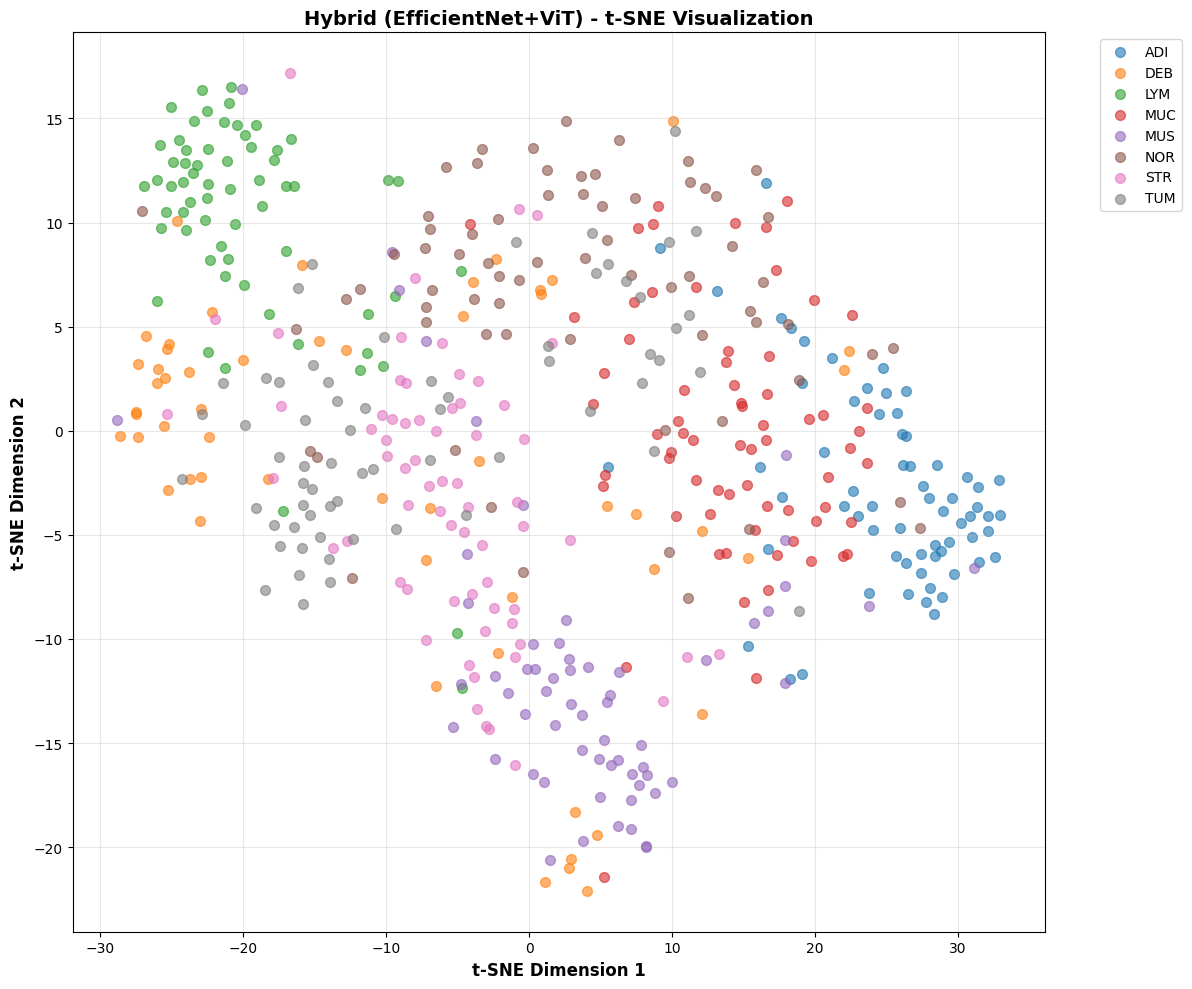

✓ Model saved locally: hybrid_final.pt
✓ Results saved locally: hybrid_results.json
⚠ Google Drive mount issue: mount failed
  Models will be saved locally only

✓ Hybrid model training completed!
✓ Model and results saved locally and to Google Drive


In [2]:
"""
Hybrid Ensemble Model: EfficientNet-B4 + ViT-Base
Run this in Google Colab Account 5
Combines CNN (EfficientNet) and Transformer (ViT) features for better performance
"""

# Setup dataset
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d orvile/gastric-cancer-histopathology-tissue-image-dataset
!unzip gastric-cancer-histopathology-tissue-image-dataset.zip -d GCHTID

# Install dependencies
!pip install timm

# Import shared utilities
import sys
sys.path.append('/content')


# Import model-specific libraries
import torch.nn as nn
import torch.optim as optim
import timm
import numpy as np

# ============================================================================
# HYBRID ENSEMBLE MODEL DEFINITION
# ============================================================================

class HybridEnsembleModel(nn.Module):
    """
    Hybrid model combining EfficientNet (CNN) and ViT (Transformer)
    Uses late fusion: concatenates features from both architectures
    """
    def __init__(self, num_classes=8, dropout=0.5):
        super().__init__()

        # EfficientNet-B4 backbone (CNN features)
        self.efficientnet = timm.create_model('efficientnet_b4', pretrained=True)
        # Get feature dimension (EfficientNet in timm uses num_features)
        eff_features = self.efficientnet.num_features
        # Remove classifier
        if hasattr(self.efficientnet, 'classifier'):
            self.efficientnet.classifier = nn.Identity()
        if hasattr(self.efficientnet, 'head'):
            self.efficientnet.head = nn.Identity()

        # ViT-Base backbone (Transformer features)
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        vit_features = self.vit.head.in_features
        self.vit.head = nn.Identity()  # Remove classifier

        # Feature fusion (concatenate, not add)
        combined_features = eff_features + vit_features  # Will be concatenated in forward

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(combined_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract CNN features (EfficientNet)
        if hasattr(self.efficientnet, 'forward_features'):
            eff_features = self.efficientnet.forward_features(x)
        else:
            # Fallback: use forward and extract before classifier
            eff_features = self.efficientnet(x)

        # Global average pooling for EfficientNet
        if len(eff_features.shape) == 4:
            # 2D feature map: [B, C, H, W] -> [B, C]
            eff_features = eff_features.mean(dim=[2, 3])
        elif len(eff_features.shape) == 3:
            # 1D sequence: [B, L, C] -> [B, C] (average over length)
            eff_features = eff_features.mean(dim=1)
        # If already [B, C], use as is

        # Extract Transformer features (ViT)
        if hasattr(self.vit, 'forward_features'):
            vit_features = self.vit.forward_features(x)
        else:
            vit_features = self.vit(x)

        # Take CLS token (first token) for ViT
        if len(vit_features.shape) == 3:
            # [B, num_patches+1, hidden_dim] -> [B, hidden_dim]
            vit_features = vit_features[:, 0]  # CLS token
        elif len(vit_features.shape) == 4:
            # 2D feature map (shouldn't happen for ViT, but handle it)
            vit_features = vit_features.mean(dim=[2, 3])
        # If already [B, C], use as is

        # Concatenate features
        combined_features = torch.cat([eff_features, vit_features], dim=1)

        # Final classification
        return self.classifier(combined_features)

    def freeze_backbones(self):
        """Freeze both backbones, train only classifier"""
        for param in self.efficientnet.parameters():
            param.requires_grad = False
        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.classifier.parameters():
            param.requires_grad = True

    def unfreeze_top_layers(self, num_layers=2):
        """Unfreeze top layers of both backbones"""
        # Unfreeze classifier
        for param in self.classifier.parameters():
            param.requires_grad = True

        # Unfreeze EfficientNet top blocks
        # EfficientNet in timm has 'blocks' as ModuleList
        if hasattr(self.efficientnet, 'blocks'):
            blocks = self.efficientnet.blocks
            # Get last N blocks
            if isinstance(blocks, (nn.ModuleList, nn.Sequential)):
                for block in list(blocks)[-num_layers:]:
                    for param in block.parameters():
                        param.requires_grad = True
            else:
                # Try as list
                try:
                    block_list = list(blocks)
                    for block in block_list[-num_layers:]:
                        for param in block.parameters():
                            param.requires_grad = True
                except:
                    # If can't unfreeze specific blocks, unfreeze all EfficientNet
                    for param in self.efficientnet.parameters():
                        param.requires_grad = True

        # Unfreeze ViT top blocks
        if hasattr(self.vit, 'blocks'):
            vit_blocks = self.vit.blocks
            for block in vit_blocks[-num_layers:]:
                for param in block.parameters():
                    param.requires_grad = True

# ============================================================================
# TRAINING FUNCTION
# ============================================================================

def train_model():
    """Main training function for Hybrid Ensemble Model"""
    set_seeds()
    device = get_device()

    # Load data (same splits as other models)
    image_paths, labels = load_dataset_paths()
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = create_splits(
        image_paths, labels
    )
    train_loader, val_loader, test_loader = create_dataloaders(
        X_train, y_train, X_val, y_val, X_test, y_test
    )

    # Initialize hybrid model
    model = HybridEnsembleModel(num_classes=NUM_CLASSES, dropout=0.5).to(device)
    model.freeze_backbones()

    print("="*60)
    print("HYBRID MODEL ARCHITECTURE")
    print("="*60)
    print("Combining:")
    print("  - EfficientNet-B4 (CNN features)")
    print("  - ViT-Base (Transformer features)")
    print("  - Late fusion: Concatenate features → Classifier")

    # Use Focal Loss for better handling of hard examples
    # Better than CrossEntropyLoss for balanced datasets with varying difficulty

    criterion = FocalLoss(alpha=0.25, gamma=2.0)
    print("✓ Using Focal Loss (alpha=0.25, gamma=2.0) for hard examples")

    # Phase 1: Train classifier only
    NUM_EPOCHS_PHASE1_HYBRID = 10
    NUM_EPOCHS_PHASE2_HYBRID = 10

    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3, weight_decay=1e-4
    )

    print("\n" + "="*60)
    print("PHASE 1: Training Classifier (Both Backbones Frozen)")
    print(f"Using {NUM_EPOCHS_PHASE1_HYBRID} epochs for hybrid model")
    print("="*60)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    OVERFIT_THRESHOLD = 15.0  # Stop if train-val gap > 15%

    for epoch in range(NUM_EPOCHS_PHASE1_HYBRID):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Calculate train-val gap
        train_val_gap = train_acc - val_acc

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS_PHASE1_HYBRID}]")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"  Val: Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
        print(f"  Train-Val Gap: {train_val_gap:.2f}%")

        # Save best model (lowest validation loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'hybrid_phase1_best.pt')
            print(f"  ✓ Best model saved")
        else:
            patience_counter += 1

        # Early stopping: multiple conditions
        should_stop = False
        stop_reason = ""

        # Condition 1: No validation improvement
        if patience_counter >= 10:
            should_stop = True
            stop_reason = "No validation improvement (patience=10)"

        # Condition 2: Overfitting detected
        if train_val_gap > OVERFIT_THRESHOLD:
            should_stop = True
            stop_reason = f"Overfitting detected (gap={train_val_gap:.2f}% > {OVERFIT_THRESHOLD}%)"

        if should_stop:
            print(f"  ⚠ Early stopping: {stop_reason}")
            break

    # Phase 2: Fine-tuning
    model.load_state_dict(torch.load('hybrid_phase1_best.pt'))
    model.unfreeze_top_layers(num_layers=2)

    # Separate parameter groups
    eff_params = []
    vit_params = []
    classifier_params = []

    for name, param in model.named_parameters():
        if 'efficientnet' in name and param.requires_grad:
            eff_params.append(param)
        elif 'vit' in name and param.requires_grad:
            vit_params.append(param)
        elif 'classifier' in name:
            classifier_params.append(param)

    optimizer_phase2 = optim.AdamW([
        {'params': classifier_params, 'lr': 1e-4},
        {'params': eff_params, 'lr': 1e-4},  # Increased from 1e-5 to 1e-4
        {'params': vit_params, 'lr': 1e-4}   # Increased from 1e-5 to 1e-4 (better fine-tuning)
    ], weight_decay=1e-4)
    print("✓ Phase 2 LRs: Classifier=1e-4, EfficientNet=1e-4, ViT=1e-4 (increased for better fine-tuning)")

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_phase2, mode='min', factor=0.5, patience=3
    )

    print("\n" + "="*60)
    print("PHASE 2: Fine-tuning Both Backbones")
    print(f"Using {NUM_EPOCHS_PHASE2_HYBRID} epochs for hybrid model")
    print("="*60)

    best_val_loss_phase2 = float('inf')
    patience_counter_phase2 = 0
    OVERFIT_THRESHOLD_PHASE2 = 15.0  # Stop if train-val gap > 15%

    for epoch in range(NUM_EPOCHS_PHASE2_HYBRID):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer_phase2, device
        )
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Calculate train-val gap
        train_val_gap = train_acc - val_acc

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS_PHASE2_HYBRID}]")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"  Val: Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
        print(f"  Train-Val Gap: {train_val_gap:.2f}%")

        # Save best model (lowest validation loss)
        if val_loss < best_val_loss_phase2:
            best_val_loss_phase2 = val_loss
            patience_counter_phase2 = 0
            torch.save(model.state_dict(), 'hybrid_final.pt')
            print(f"  ✓ Best model saved")
        else:
            patience_counter_phase2 += 1

        # Early stopping: multiple conditions
        should_stop = False
        stop_reason = ""

        # Condition 1: No validation improvement
        if patience_counter_phase2 >= 10:
            should_stop = True
            stop_reason = "No validation improvement (patience=10)"

        # Condition 2: Overfitting detected
        if train_val_gap > OVERFIT_THRESHOLD_PHASE2:
            should_stop = True
            stop_reason = f"Overfitting detected (gap={train_val_gap:.2f}% > {OVERFIT_THRESHOLD_PHASE2}%)"

        if should_stop:
            print(f"  ⚠ Early stopping: {stop_reason}")
            break

    # Final evaluation
    model.load_state_dict(torch.load('hybrid_final.pt'))
    results = evaluate_model(model, test_loader, criterion, device)

    print("\n" + "="*60)
    print("HYBRID ENSEMBLE (EfficientNet+ViT) FINAL RESULTS")
    print("="*60)
    print(f"Test Accuracy: {results['test_acc']:.2f}%")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"MCC: {results['mcc']:.4f}")

    # Visualizations
    plot_confusion_matrix(
        results['labels'], results['predictions'],
        'Hybrid (EfficientNet+ViT)', save_path='hybrid_cm.png'
    )

    # Extract features for t-SNE (from combined features)
    try:
        model.eval()
        features_list = []
        labels_list = []
        count = 0
        max_samples = 500

        with torch.no_grad():
            for images, labels in test_loader:
                if count >= max_samples:
                    break
                images = images.to(device)

                # Extract combined features
                eff_feat = model.efficientnet.forward_features(images)
                vit_feat = model.vit.forward_features(images)

                # Process features
                if len(eff_feat.shape) == 4:
                    eff_feat = eff_feat.mean(dim=[2, 3])
                elif len(eff_feat.shape) == 3:
                    eff_feat = eff_feat.mean(dim=1)

                if len(vit_feat.shape) == 3:
                    vit_feat = vit_feat[:, 0]

                # Concatenate
                combined = torch.cat([eff_feat, vit_feat], dim=1)
                features_list.append(combined.cpu().numpy())
                labels_list.extend(labels.numpy())
                count += len(labels)

        if features_list:
            features_array = np.vstack(features_list)
            labels_array = np.array(labels_list[:len(features_array)])
            plot_tsne(features_array, labels_array, 'Hybrid (EfficientNet+ViT)',
                     save_path='hybrid_tsne.png')
    except Exception as e:
        print(f"Could not extract features for t-SNE: {e}")

    # Save model and results (local + Google Drive)
    # save_model_and_results is already imported via 'from shared_utilities import *'
    save_model_and_results(model, results, 'hybrid', save_to_drive=True)

    print("\n✓ Hybrid model training completed!")
    print("✓ Model and results saved locally and to Google Drive")

    return model, results, history

if __name__ == '__main__':
    model, results, history = train_model()